In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn
from sklearn.metrics import f1_score, roc_auc_score
from src.utils import load_ei_results, f_baseline
from src.load_data import load_data, load_data_by_filename
plt.rcParams["font.family"] = ['Arial']
plt.rcParams['font.size'] = '8'
plt.rc('legend',fontsize=7)
plt.rc('legend',fontsize=7)
plt.rc('xtick', labelsize=7)
plt.rc('ytick', labelsize=7)
blues_palette = seaborn.color_palette("Blues_r", n_colors=3)

### Define results path

In [2]:
dirname = os.path.dirname(os.path.dirname(os.getcwd())) 
results_path = os.path.join(dirname, "results")
save_path = os.path.join(dirname, "figures/testing")

modalityIDs = ["ERK+Akt", "ERK", "Akt"]
dataset_names = ["High-dose (train)", "High-dose (test)", "Low-dose (test)"]

df = pd.DataFrame(columns=["F-score", "AUC-score", "Model", "Data set"])

### Load cross validation performance on training data

In [3]:
f_train = []
auc_train = []
_, meta = load_ei_results(os.path.join(results_path, "models/EI.ERK_Akt"))
f_train.append(meta["fmax (minority)"].to_numpy().item())
auc_train.append(meta["auc"].to_numpy().item())
_, meta = load_ei_results(os.path.join(results_path, "models/EI.ERK"))
f_train.append(meta["fmax (minority)"].to_numpy().item())
auc_train.append(meta["auc"].to_numpy().item())
_, meta = load_ei_results(os.path.join(results_path, "models/EI.Akt"))
f_train.append(meta["fmax (minority)"].to_numpy().item())
auc_train.append(meta["auc"].to_numpy().item())

for i in range(3):
    df.loc[len(df.index)] = f_train[i], auc_train[i], modalityIDs[i], dataset_names[0]

### Load predictions on test data and calculate performance scores

In [4]:
test_high = [pd.read_csv(os.path.join(results_path, "testing/mcf10a/high_dose", f"predictions_ERK_Akt.csv")),
                pd.read_csv(os.path.join(results_path, "testing/mcf10a/high_dose", f"predictions_ERK.csv")),
                pd.read_csv(os.path.join(results_path, "testing/mcf10a/high_dose", f"predictions_Akt.csv"))]
                
test_low = [pd.read_csv(os.path.join(results_path, "testing/mcf10a/low_dose", f"predictions_ERK_Akt.csv")),
               pd.read_csv(os.path.join(results_path, "testing/mcf10a/low_dose", f"predictions_ERK.csv")),
               pd.read_csv(os.path.join(results_path, "testing/mcf10a/low_dose", f"predictions_Akt.csv"))]

test_high_dict = dict(zip(modalityIDs, test_high))
test_low_dict = dict(zip(modalityIDs, test_low))

In [5]:
f_high = [f1_score(test_high_dict[modality_id]["labels"], test_high_dict[modality_id]["inference"]) for modality_id in modalityIDs]
f_low = [f1_score(test_low_dict[modality_id]["labels"], test_low_dict[modality_id]["inference"]) for modality_id in modalityIDs]
auc_high = [roc_auc_score(test_high_dict[modality_id]["labels"], test_high_dict[modality_id]["predictions"]) for modality_id in modalityIDs]
auc_low =  [roc_auc_score(test_low_dict[modality_id]["labels"], test_low_dict[modality_id]["predictions"]) for modality_id in modalityIDs]

for i in range(3):
    df.loc[len(df.index)] = f_high[i], auc_high[i], modalityIDs[i], dataset_names[1]
    df.loc[len(df.index)] = f_low[i], auc_low[i], modalityIDs[i], dataset_names[2]

### Load baselines

In [7]:
_, _, y, _ = load_data(os.path.join(dirname, "data/processed/mcf10a/high_dose/train"))
f_train_baseline = f_baseline(y)

_, _, y, _ = load_data(os.path.join(dirname, "data/processed/mcf10a/high_dose/test"))
f_high_baseline = f_baseline(y)

_, _, y, _ = load_data(os.path.join(dirname, "data/processed/mcf10a/low_dose/test"))
f_low_baseline = f_baseline(y)

### Figure parameters

In [8]:
dataset_label = "Data set"
f_label = r"F score (divided class)"
auc_label = r"AUC score"

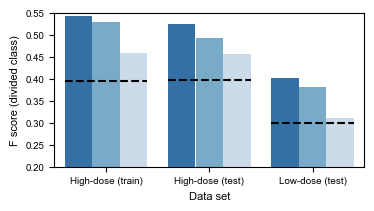

In [11]:
fig, ax = plt.subplots(1, 1,figsize=(4, 2))

plot1 = seaborn.barplot(ax=ax, data=df, x="Data set", y="F-score", hue="Model",
                palette=blues_palette)

ax.hlines(f_train_baseline, xmin=-0.4, xmax=0.4, color="black", linestyle="--", label="Random classifier")
ax.hlines(f_high_baseline, xmin=-0.4+1, xmax=0.4+1, color="black", linestyle="--")
ax.hlines(f_low_baseline, xmin=-0.4+2, xmax=0.4+2, color="black", linestyle="--")

ax.set_xlabel(dataset_label)
ax.set_ylabel(f_label)

handles, labels = ax.get_legend_handles_labels()

order = [1, 2, 3, 0]

handles = [handles[index] for index in order]
labels = [labels[index] for index in order]

ax.legend(handles[:], labels[:], title="")

plt.legend([],[], frameon=False)

ax.set_xlim(xmin=-0.5, xmax=2.5)
ax.set_ylim(ymin=0.2, ymax=0.55)
          
seaborn.move_legend(ax, "upper right")

plt.savefig(os.path.join(save_path, "f_test.svg"), dpi=300)

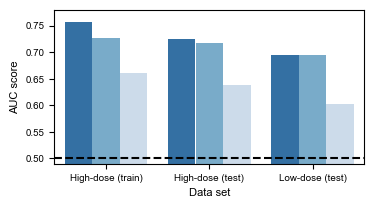

In [12]:
fig, ax = plt.subplots(1, 1,figsize=(4, 2))

plot1 = seaborn.barplot(ax=ax, data=df, x="Data set", y="AUC-score", hue="Model",
                palette=blues_palette)

ax.hlines(0.5, xmin=-5, xmax=5, color="black", linestyle="--", label = "Random classifier")

ax.set_xlabel(dataset_label)
ax.set_ylabel(auc_label)

handles, labels = ax.get_legend_handles_labels()

order = [1, 2, 3, 0]

handles = [handles[index] for index in order]
labels = [labels[index] for index in order]

ax.legend(handles[:], labels[:], title="")

plt.legend([],[], frameon=False)

ax.set_xlim(xmin=-0.5, xmax=2.5)
ax.set_ylim(ymin=0.49, ymax=0.78)
          
seaborn.move_legend(ax, "upper right")

plt.savefig(os.path.join(save_path, "auc.svg"), dpi=300)

In [13]:
fig = plt.figure(figsize=(7, 2))
fig.legend(handles=handles, labels=labels, ncol = len(ax.lines))
plt.savefig(os.path.join(save_path, "legend.svg"), dpi=300)

<Figure size 700x200 with 0 Axes>

### Show scores

In [14]:
df

,F-score,AUC-score,Model,Data set
0,0.542373,0.757114,ERK+Akt,High-dose (train)
1,0.528239,0.726551,ERK,High-dose (train)
2,0.459064,0.660806,Akt,High-dose (train)
3,0.524390,0.725636,ERK+Akt,High-dose (test)
4,0.400560,0.694747,ERK+Akt,Low-dose (test)
5,0.493671,0.717486,ERK,High-dose (test)
6,0.382222,0.694547,ERK,Low-dose (test)
7,0.455090,0.638974,Akt,High-dose (test)
8,0.311721,0.603350,Akt,Low-dose (test)
